In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import mido 
import os

In [3]:
def loadPieces(dir):
	pieces = {}

	for folder in os.listdir(dir):
		path = os.path.join(dir, folder)
		for fname in os.listdir(path):
			if fname[-4:] not in ('.mid', '.MID'):
				continue
			name = fname[:-4]
			piece = os.path.join(path, fname)

			pieces[name] = piece
		print('Loaded {} pieces'.format(folder))
	return pieces

In [4]:
def readNotes(piece, time):
	midi = mido.MidiFile(piece)
	data = []
	on = np.zeros(128, dtype=int)

	for msg in mido.merge_tracks(midi.tracks):
		time['value'] = time['value'] + msg.time

		if msg.type == 'time_signature':
			print(msg)

		if msg.type == 'note_on':
			if msg.velocity > 0:
				on[msg.note] = time['value']

			else:
				if on[msg.note]:
					off = time['value']
					length = off - on[msg.note]

					# Minimum hearing length
					if length > 4: 
						data.append((msg.note, on[msg.note], off, length))
					on[msg.note] = 0
	return pd.DataFrame(data, columns=['pitch', 'on', 'off', 'length'])

In [5]:
def extractPieces(pieces):
	print('Extracting notes...')
	dataframe = pd.DataFrame()
	time = { 'value': 0 }
	frames = [readNotes(piece, time) for piece in pieces.values()]
	return pd.concat(frames)

In [6]:
def pianoRoll(df):
	maxPitch = 0
	minPitch = 128
	totalwidth = df['off'].values[-1]

	for note in df.itertuples():
		start = getattr(note, 'on')
		pitch = getattr(note, 'pitch')
		width = getattr(note, 'length')
		rectangle = plt.Rectangle((start, pitch), width, 1, fc='r')
		plt.gca().add_patch(rectangle)

		if pitch > maxPitch:
			maxPitch = pitch
		if pitch < minPitch:
			minPitch = pitch

	plt.xlim(0, totalwidth) 
	plt.ylim(minPitch, maxPitch + 1)
	plt.show()

In [7]:
COUNTER = {}
COUNTER['<>60'] = 0
COUNTER['==60'] = 0

In [8]:
def quantize(tick):
    quantizationUnit = 60
    res = tick % quantizationUnit
    if res != 0:
        COUNTER['<>60'] += 1
        if res < (quantizationUnit / 2):
            tick -= res
        if res >= (quantizationUnit / 2):
            tick += (quantizationUnit - res)
    if res == 0:
        COUNTER['==60'] +=1
    return tick

In [9]:
pieces = loadPieces('music')
df = extractPieces(pieces)

Loaded Mozart pieces
Extracting notes...
<meta message time_signature numerator=4 denominator=4 clocks_per_click=24 notated_32nd_notes_per_beat=8 time=0>


In [10]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 10]

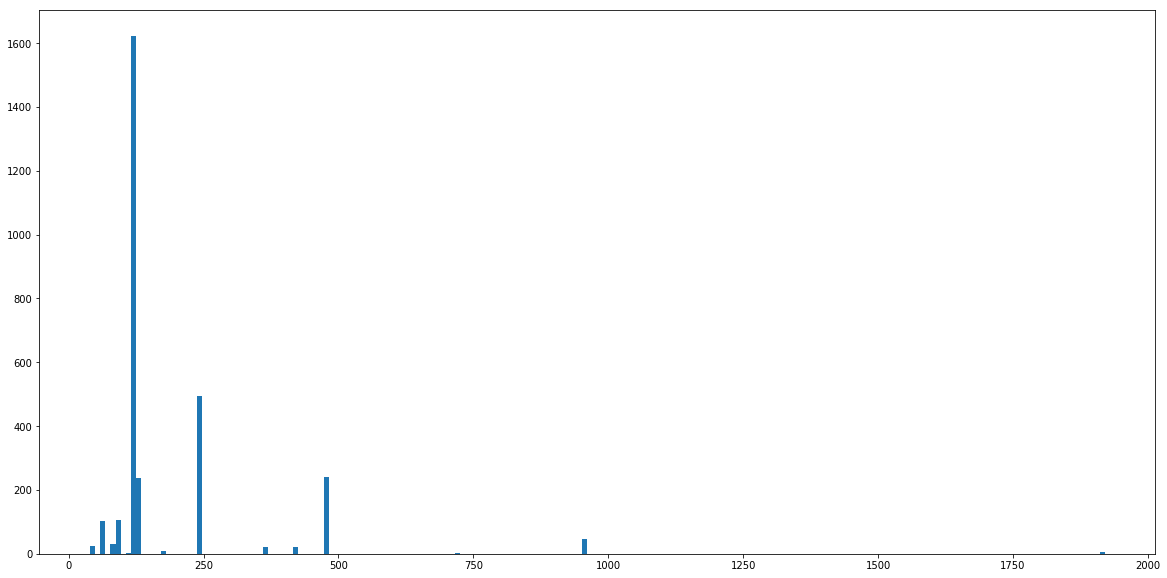

In [11]:
# Nekvantuota
plt.hist(df['length'], bins=200)
plt.show()

In [12]:
df['on'] = df['on'].apply(lambda x: quantize(x))
df['off'] = df['off'].apply(lambda x: quantize(x))

In [13]:
def findLength(on, off):
    return off - on

In [14]:
df['length'] = df.apply(lambda x: findLength(x['on'], x['off']), axis=1)

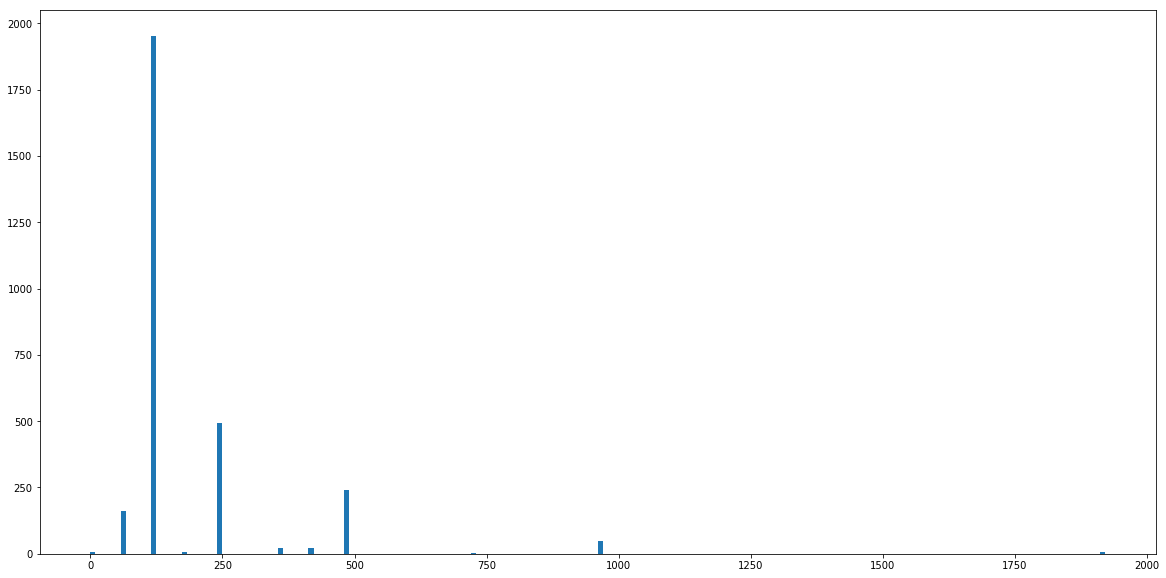

In [15]:
plt.hist(df['length'], bins=200)
plt.show()

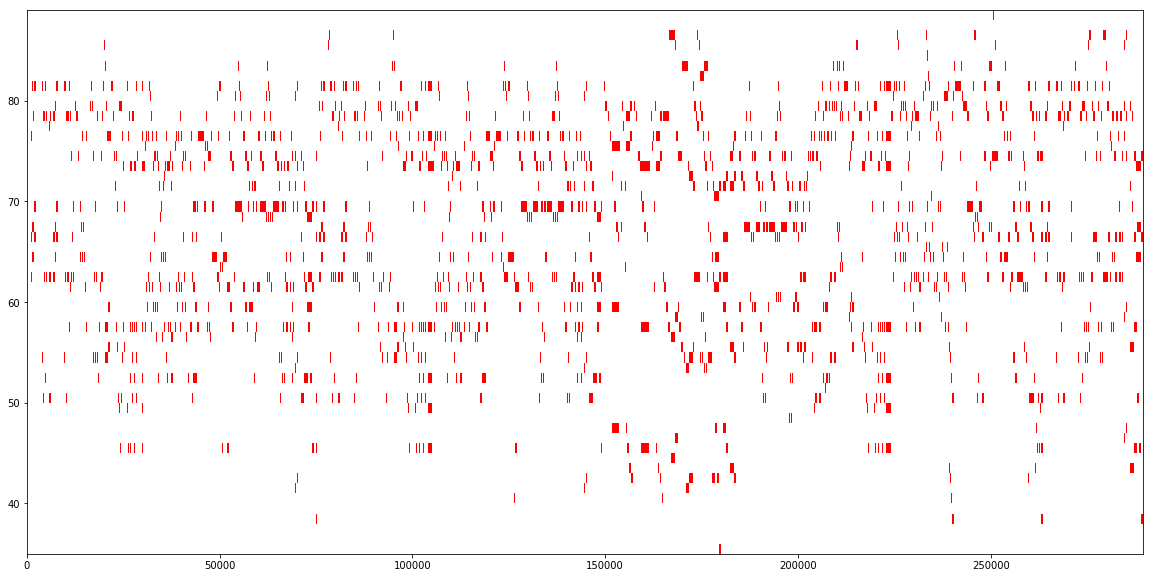

In [16]:
pianoRoll(df)

In [17]:
len(df)

2964

In [18]:
int(COUNTER['<>60']/2)

226

In [19]:
int(COUNTER['==60']/2)

2738

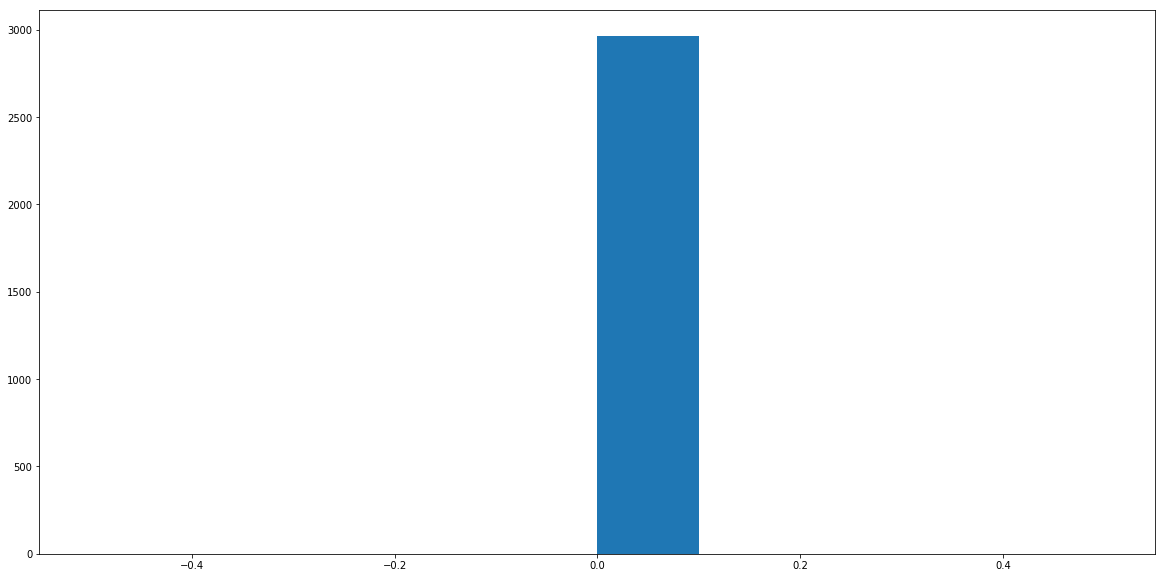

In [20]:
plt.hist(df['on'] % 60)
plt.show()

In [21]:
def toStateMatrix():
    length = df['off'].values[-1]
    steps = int(length / 60)
    stateMatrix = np.zeros((steps, 128), dtype=int)
    for row in df.itertuples():
        pitch = row[1]
        on = row[2]
        off = row[3]
        stateMatrix[int((on/60)) : int((off/60+1)), pitch] = 1
    return stateMatrix

In [22]:
stateMatrix = toStateMatrix()

In [24]:
np.insert([55, 99], 0, 147)

array([147,  55,  99])

In [30]:
df

,pitch,on,off,length
0,79,960,1080,120
1,78,1080,1200,120
2,76,1200,1320,120
3,62,960,1440,480
4,66,960,1440,480
5,78,1320,1440,120
6,81,1440,1560,120
7,79,1560,1680,120
8,78,1680,1800,120
9,67,1440,1920,480


In [93]:
def stateToMessage():
    data = []
    notes = np.zeros(128, dtype=int)
    song = mido.MidiFile()
    track = mido.MidiTrack()
    song.tracks.append(track)
    for index, state in enumerate(stateMatrix):
        for i in range(128):
            if state[i] == 1:
                if notes[i] != 1:
                    notes[i] = 1
                    time = index * 60
                    data.append((147, i, 80, time))
            if index != 0:
                if state[i] == 0:
                    if stateMatrix[index - 1, i] == 1:
                        notes[i] = 0
                        time = (index - 1) * 60
                        data.append((147, i, 0, time))
    sortedData = sorted(data, key=lambda x: x[-1])
    return sortedData

In [94]:
messages = stateToMessage()

In [95]:
def toMidi():
    song = mido.MidiFile()
    track = mido.MidiTrack()
    song.tracks.append(track)
    time = 0
    for message in messages:
        message = np.array(message)
        now = message[-1]
        delta = now - time
        time = now
        message[-1] = delta
        msg = mido.Message.from_bytes(message[:3])
        msg.time = delta
        track.append(msg)
    song.save('Midi.mid')

In [96]:
toMidi()

In [61]:
sortedMessages

[(147, 62, 60, 960),
 (147, 66, 60, 960),
 (147, 79, 60, 960),
 (147, 78, 60, 1080),
 (147, 79, 0, 1080),
 (147, 76, 60, 1200),
 (147, 78, 0, 1200),
 (147, 78, 60, 1320),
 (147, 76, 0, 1320),
 (147, 64, 60, 1440),
 (147, 67, 60, 1440),
 (147, 81, 60, 1440),
 (147, 62, 0, 1440),
 (147, 66, 0, 1440),
 (147, 78, 0, 1440),
 (147, 79, 60, 1560),
 (147, 81, 0, 1560),
 (147, 78, 60, 1680),
 (147, 79, 0, 1680),
 (147, 79, 60, 1800),
 (147, 78, 0, 1800),
 (147, 66, 60, 1920),
 (147, 69, 60, 1920),
 (147, 81, 60, 1920),
 (147, 64, 0, 1920),
 (147, 67, 0, 1920),
 (147, 79, 0, 1920),
 (147, 66, 0, 2400),
 (147, 69, 0, 2400),
 (147, 81, 0, 2400),
 (147, 81, 60, 2880),
 (147, 81, 0, 2940),
 (147, 83, 60, 3120),
 (147, 83, 0, 3180),
 (147, 85, 60, 3360),
 (147, 85, 0, 3420),
 (147, 86, 60, 3600),
 (147, 86, 0, 3660),
 (147, 54, 60, 3840),
 (147, 81, 60, 3840),
 (147, 62, 60, 4080),
 (147, 54, 0, 4080),
 (147, 50, 60, 4320),
 (147, 78, 60, 4320),
 (147, 62, 0, 4320),
 (147, 81, 0, 4320),
 (147, 62, 60

In [28]:
df

,pitch,on,off,length
0,79,960,1080,120
1,78,1080,1200,120
2,76,1200,1320,120
3,62,960,1440,480
4,66,960,1440,480
5,78,1320,1440,120
6,81,1440,1560,120
7,79,1560,1680,120
8,78,1680,1800,120
9,67,1440,1920,480
